In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from cheyette.curves import FlatCurve
from cheyette.products import BondOpt, OptionType
from cheyette.processes import VasicekProcess
from cheyette.discretization import PeacemanRachford
from cheyette.boundary_conditions import DirichletIntrinsicBC
from cheyette.models import CheyettePDEModel, CheyetteAnalyticModel
from cheyette.pricers import CheyettePricer

plt.style.use('input/qulib.mplstyle')

# Bond option pricing

In [2]:
curve = FlatCurve(short_rate=0.01)
process = VasicekProcess(mean_rev=0.01, local_vol=0.02)

model_pde = CheyettePDEModel(x_grid_stddevs=5.0, y_grid_stddevs=5.0,
                    x_freq=3, y_freq=3, t_freq=10,
                    stepping_method=PeacemanRachford(),
                    x_lower_bc=DirichletIntrinsicBC(), x_upper_bc=DirichletIntrinsicBC(),
                    y_lower_bc=DirichletIntrinsicBC(), y_upper_bc=DirichletIntrinsicBC())

model_analytic = CheyetteAnalyticModel()

product = BondOpt(strike=0.98, expiry=10.0, bond_expiry=20.0, option_type=OptionType.call)

pricer_pde = CheyettePricer(model_pde, curve, process, product, valuation_time=0.0)
pricer_analytic = CheyettePricer(model_analytic, curve, process, product, valuation_time=0.0)

notional = 10000.0

pv_pde = pricer_pde.price()['PV']*notional
pv_analytic = pricer_analytic.price()['PV']*notional

print(f'PDE PV: {pv_pde}')
print(f'Analytic PV: {pv_analytic}')
print(f'Abs. Error: {pv_pde - pv_analytic}')

PDE PV: 1623.050145569949
Analytic PV: 1600.9631118121265
Abs. Error: 22.08703375782261


## FDM Convergence

In [15]:
pv_freq_analytic = pricer_analytic.price()['PV']*notional

freqs = np.arange(3, 22, 3)
pvs_freq_pde = [pricer_pde.set('model', model_pde.set('x_freq', f).set('y_freq', f)).price()['PV']*notional for f in freqs]

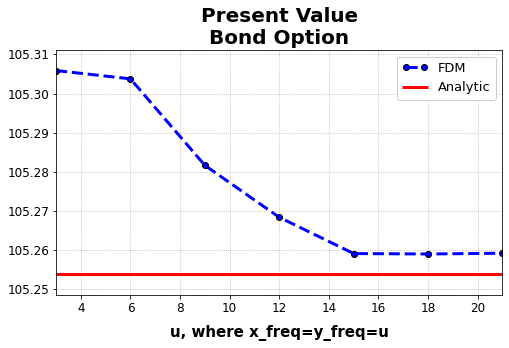

In [20]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(freqs, pvs_freq_pde, label='FDM')
ax.set_xlabel('u, where x_freq=y_freq=u')
ax.set_title('Present Value\nBond Option')
ax.hlines(pv_freq_analytic, freqs[0], freqs[-1], color='r', label='Analytic')
ax.legend()

# Curve Bumps

In [3]:
short_rates = np.arange(-0.05, 0.0501, 0.01)
pvs_curve_pde = [pricer_pde.set('curve', curve.set('short_rate', r)).price()['PV']*notional for r in short_rates]
pvs_curve_analytic = [pricer_analytic.set('curve', curve.set('short_rate', r)).price()['PV']*notional for r in short_rates]

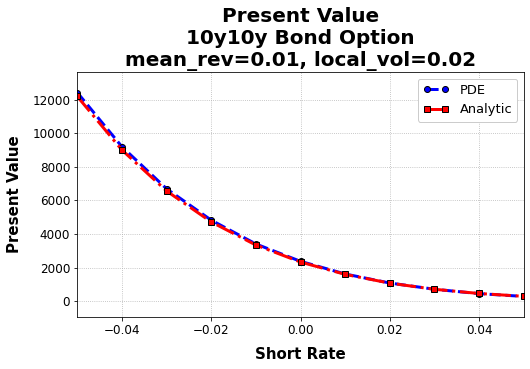

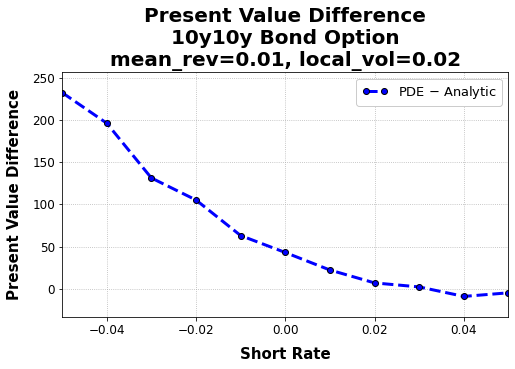

In [4]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, pvs_curve_pde, label='PDE')
ax.plot(short_rates, pvs_curve_analytic, label='Analytic')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value')
ax.set_title(f'Present Value\n'\
             f'{product.expiry:.0f}y{product.bond_expiry-product.expiry:.0f}y Bond Option\n'\
             f'mean_rev={process.mean_rev:.2f}, local_vol={process.local_vol:.2f}')
ax.legend()

diff = [y - x for x, y in zip(pvs_curve_analytic, pvs_curve_pde)]
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, diff, label='PDE $-$ Analytic')
ax.set_xlabel('Short Rate')
ax.set_ylabel('Present Value Difference')
ax.set_title(f'Present Value Difference\n'\
             f'{product.expiry:.0f}y{product.bond_expiry-product.expiry:.0f}y Bond Option\n'\
             f'mean_rev={process.mean_rev:.2f}, local_vol={process.local_vol:.2f}')
ax.legend()

# Volatility Bumps

In [16]:
mults = np.arange(-0.9, 2.1, 0.1)
default_vol = 0.02
model_pde.set('x_freq', 3).set('y_freq', 3)
pvs_vols_pde = [pricer_pde.set('process', process.set('local_vol', (1+m)*default_vol)).price()['PV']*notional for m in mults]
pvs_vols_analytic = [pricer_analytic.set('process', process.set('local_vol', (1+m)*default_vol)).price()['PV']*notional for m in mults]

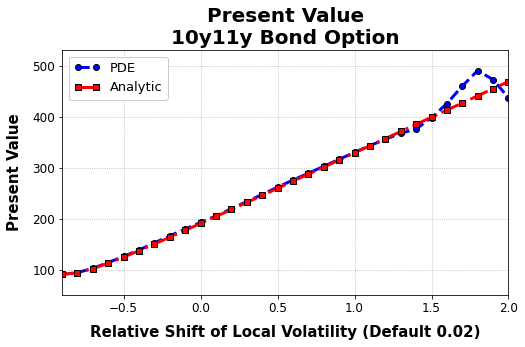

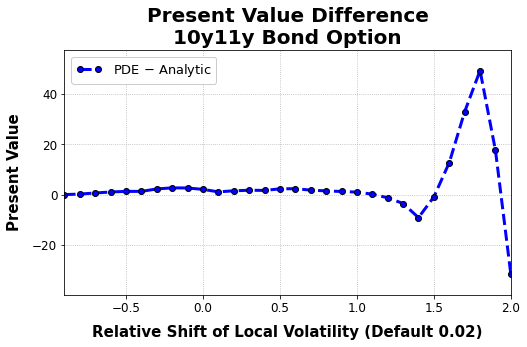

In [22]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, pvs_vols_pde, label='PDE')
ax.plot(mults, pvs_vols_analytic, label='Analytic')
ax.set_xlabel(f'Relative Shift of Local Volatility (Default {default_vol})')
ax.set_ylabel('Present Value')
ax.set_title(f'Present Value\n{product.expiry:.0f}y{product.bond_expiry:.0f}y Bond Option')
ax.legend()

diff = [y - x for x, y in zip(pvs_vols_analytic, pvs_vols_pde)]
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, diff, label='PDE $-$ Analytic')
ax.set_xlabel(f'Relative Shift of Local Volatility (Default {default_vol})')
ax.set_ylabel('Present Value')
ax.set_title(f'Present Value Difference\n{product.expiry:.0f}y{product.bond_expiry:.0f}y Bond Option')
ax.legend()